# MIR Project: melody segmentation
Prepared by Philip Tovstogan

This project evaluates the performance of two melody segmentation algorithms:

### Local Boundary Detection Model (LBDM) by Cambouropoulos ([MATLAB code](https://github.com/miditoolbox/1.1/blob/master/miditoolbox/boundary.m))

*Cambouropoulos, E. (1997). Musical rhythm: A formal model for determining local boundaries, accents and metre in a melodic surface. In M. Leman (Ed.), Music, Gestalt, and Computing: Studies in Cognitive and Systematic Musicology (pp. 277-293). Berlin: Springer Verlag.*


### Segmentation algorithm by Tenney & Polansky ([MATLAB code](https://github.com/miditoolbox/1.1/blob/master/miditoolbox/segmentgestalt.m))

*Tenney, J.  & Polansky, L. (1980). Temporal gestalt perception in music. Journal of Music Theory, 24(2), 205–41.*

The dataset that is used for evaluation is [SymbTr](https://github.com/MTG/makam-symbolic-phrase-segmentation) that is a collection of Turkish Makam music with ground-truth annotations for phrase boundaries.

*NOTE: this code depends on [SymbTr extractor](https://github.com/sertansenturk/symbtrdataextractor) that is not present in MIRCourse docker image*

In [1]:
import music21 as m21
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Function Implementations

LBDM implementation is taken from Baris' notebook from MIRCourse (available [here](https://github.com/philtgun/MIRCourse/blob/master/notebooks/Lecture6_melodicSegmentation.ipynb)) with small modifications

In [2]:
def lbdm(midi_data):
    """Implementing LBDM as in Miditoolbox (boundary.m)"""
    note_midi = np.array([note.pitch.midi for note in midi_data.recurse().notes])
    pitch_profile = np.abs(note_midi[1:] - note_midi[:-1])  # Miditoolbox variable 'pp'
    
    onsets = []  # Miditoolbox variable 'on'
    offsets_org = []
    durations = []
    
    for note in midi_data.recurse().notes:
        if type(note) is m21.note.Note:  # avoid data without duration, not a note event
            if len(onsets) > 0 and note.offset < onsets[-1]:  # non-monophonic midi files?
                break
            onsets.append(note.offset)
            durations.append(note.duration.quarterLength)
            offsets_org.append(note.offset)
    
    pitch_profile = pitch_profile[:len(onsets)]
    onsets = np.array(onsets)
    durations = np.array(durations)
    offsets = onsets + durations  # Miditoolbox variable 'off'

    ioi_profile = onsets[1:] - onsets[:-1]  # Miditoolbox variable 'po'
    rest_profile = onsets[1:] - offsets[:-1]  # Miditoolbox variable 'pr'
    rest_profile = (rest_profile + np.abs(rest_profile)) / 2  # half wave rect. (max(0,x) in Miditoolbox)

    # degrees of change [see boundary.m]
    rp = np.abs(pitch_profile[1:] - pitch_profile[:-1]) / (0.000001 + pitch_profile[1:] + pitch_profile[:-1])
    rp = np.append(rp,0)
    ro = [np.abs(ioi_profile[1:] - ioi_profile[:-1]) / (0.000001 + ioi_profile[1:] + ioi_profile[:-1])]
    ro = np.append(ro,0)
    rr = [np.abs(rest_profile[1:] - rest_profile[:-1]) / (0.000001 + rest_profile[1:] + rest_profile[:-1])]
    rr = np.append(rr,0)

    # strengths
    sp = pitch_profile * np.append(0, rp[:-1] + rp[1:])
    if np.max(sp) > 0.1:
        sp = sp / np.max(sp)

    so = ioi_profile*np.append(0, ro[:-1] + ro[1:])
    if np.max(so) > 0.1:
        so = so / np.max(so)

    sr = rest_profile * np.append(0, rr[:-1] + rr[1:])
    if np.max(sr) > 0.1:
        sr = sr / np.max(sr)

    # overall profile
    return onsets, np.append(1, 0.25*sp + 0.5*so + 0.25*sr)

Implementation of another segmentation algorithm that is based on gestalt principles from the MidiToolbox for MATLAB. It closely follows original MATLAB code and has been verified with the same example that is used in the MidiToolbox manual 

In [3]:
def gestalt(midi_data):
    """Implementing segmentation as in Miditoolbox (segmentgestalt.m)"""
    
    onsets = []  # Miditoolbox variable 'on'
    durations = []  # Miditoolbox variable 'du'
    pitches = []  # Miditoolbox variable 'p'
    
    for note in midi_data.recurse().notes:
        if type(note) is m21.note.Note:  # avoid rests (don't need to worry about chords)
            if len(onsets) > 0 and note.offset < onsets[-1]:  # corrupted midi files?
                break

            onsets.append(note.offset)
            durations.append(note.duration.quarterLength)
            pitches.append(note.pitch.midi)
            
    onsets = np.array(onsets)
    durations = np.array(durations)
    offsets = onsets + durations  # Miditoolbox variable 'off'
    pitches = np.array(pitches)

    # clang boundaries
    clangs = 2 * (onsets[1:] - onsets[:-1]) + np.abs(pitches[1:] - pitches[:-1])  # Miditoolbox variable 'cl'
    clang_boundaries = np.logical_and(clangs[1:-1] > clangs[:-2], clangs[1:-1] > clangs[2:])  # Miditoolbox variable 'clb'
    clang_indices = np.nonzero(clang_boundaries)[0] + 2  # Miditoolbox variable 'clind'
    
    # segment boundaries
    clang_starts = np.append(0, clang_indices)  # Miditoolbox variable 'first'
    clang_ends = np.append(clang_indices, len(onsets))  # Miditoolbox variable 'last'

    # mean pitch of segments
    mean_pitches = []  # Miditoolbox variable 'meanp'
    for k in range(len(clang_starts)):
        seg = np.arange(clang_starts[k], clang_ends[k])
        mean_pitches.append(np.dot(pitches[seg], durations[seg]) / np.sum(durations[seg]))
    mean_pitches = np.array(mean_pitches)

    segment_distances = (np.abs(mean_pitches[1:] - mean_pitches[:-1]) +  # Miditoolbox variable 'segdist'
                        onsets[clang_starts[1:]] - onsets[clang_starts[:-1]] + 
                        np.abs(pitches[clang_starts[1:]] - pitches[clang_ends[:-1]-1]) + 
                        2 * (onsets[clang_starts[1:]] - onsets[clang_ends[:-1]-1]) )

    segment_boundaries = np.logical_and(segment_distances[1:-1] > segment_distances[:-2],  # Miditoolbox variable 'segb'
                          segment_distances[1:-1] > segment_distances[2:])

    segment_indices = np.nonzero(segment_boundaries)[0] + 2  # Miditoolbox variable 'segind'

    clang_ret = np.zeros_like(onsets, dtype=bool)  # Miditoolbox variable 'c'
    clang_ret[clang_indices] = 1
    
    clang_nonzero = np.nonzero(clang_ret > 0)[0]  # Miditoolbox variable 'j'
    segment_ret = np.zeros_like(onsets, dtype=bool)  # Miditoolbox variable 'z'
    segment_ret[clang_nonzero[segment_indices - 1]] = 1
    
    return onsets, clang_ret, segment_ret

Helper function to bring midi onsets that are measured in quarter note lengths to the SymbTr onsets measured in bars.

In [4]:
# Normalization factor for onsets to match annotations
def get_quarters_per_measure(midi_data):
    ts = test_data.getTimeSignatures()[0]
    return float(ts.numerator) / ts.denominator * 4

## Retrieving data
Requires git client and unix-like environment

In [24]:
!git clone https://github.com/MTG/SymbTr.git
!mv SymbTr/midi SymbTr/txt .

Cloning into 'SymbTr'...
remote: Counting objects: 51780, done.
remote: Total 51780 (delta 0), reused 0 (delta 0), pack-reused 51780
Receiving objects: 100% (51780/51780), 100.45 MiB | 9.56 MiB/s, done.
Resolving deltas: 100% (42440/42440), done.
Checking out files: 100% (8820/8820), done.


## Visualizing algorithms
Let's use one file to explore and visualize results of two segmentation algorithms

In [5]:
test_filename = 'hicaz--sarki--aksak--su_karsiki--dede_efendi'
midi_data = m21.converter.parse('midi/{}.mid'.format(test_filename))

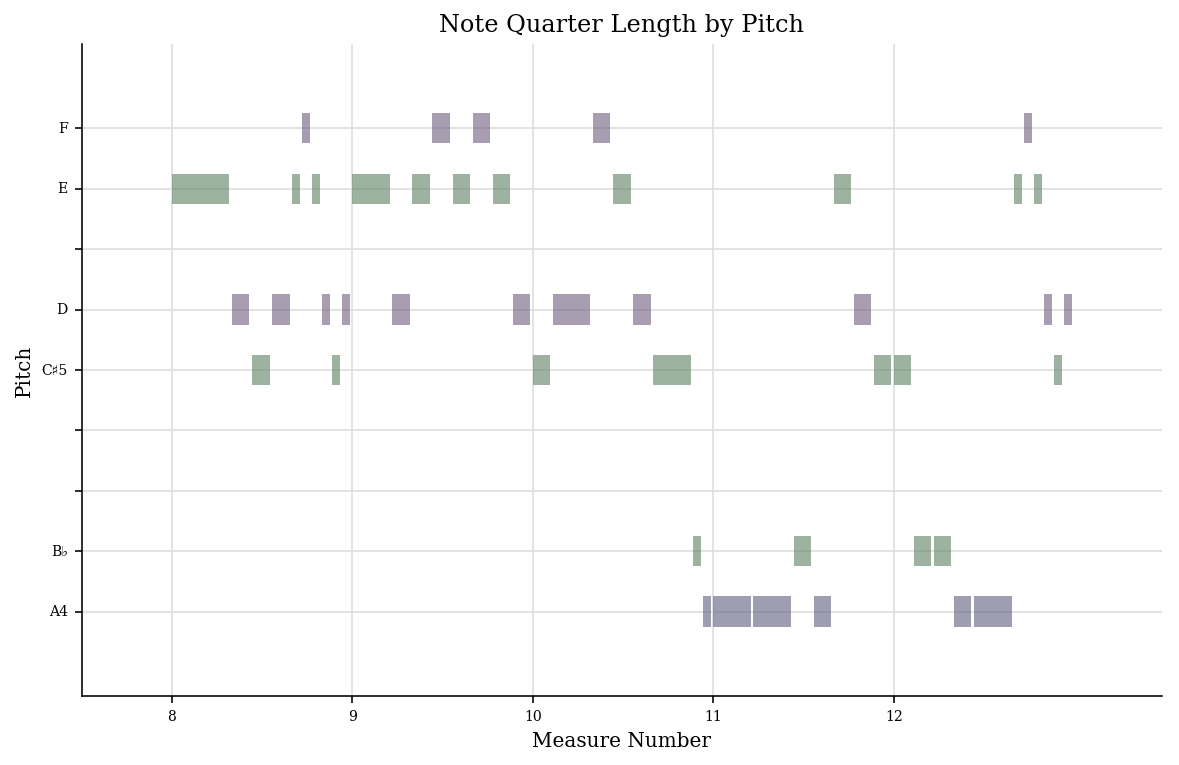

In [6]:
# test_data = midi_data.measures(1, 4)
test_data = midi_data
test_data.measures(8, 12).plot()

### LBDM
LBDM algorithm provides profile function as an output that can be used to detect boundaries

In [7]:
onsets, profile = lbdm(test_data)
qpm = get_quarters_per_measure(test_data)
onsets = onsets / qpm   # normalize onsets
end = test_data.duration.quarterLength / qpm  # total duration that serves as last boundary

Text(0.5,1,'LBDM')

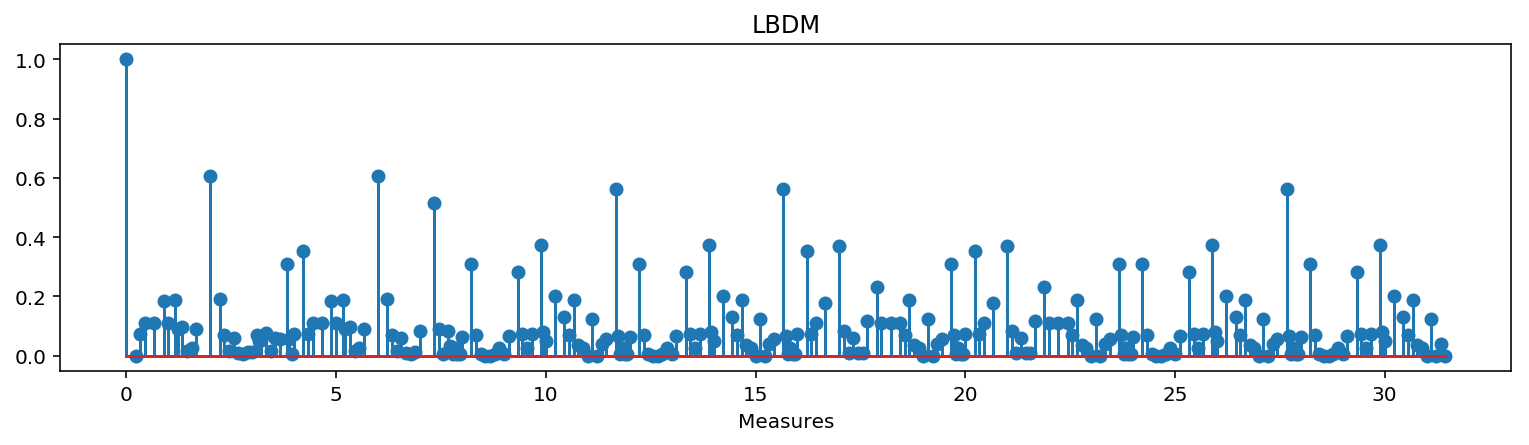

In [8]:
plt.figure(figsize=(13, 3))
plt.stem(onsets, profile)
plt.xlabel('Measures')
plt.title('LBDM')

High values of profile function mean that there is a higher probability of section boundary. Thus the profile function should be used together with the threshold value to produce section boundary onsets

### Gestalt
Gestalt algorithm outputs a binary vector of the same size as onset vector. Boundaries are indicated by ones from the vector. Moreover, gestalt outputs two boundary vectors: clangs and segments. Clang boundaries are an imtermediate product, while segment boundaries are the actual output.

In [9]:
onsets, clangs, segments = gestalt(test_data)
gestalt_profile = clangs * 0.5 + segments * 0.5
onsets = onsets / qpm

Text(0.5,1,'Gestalt')

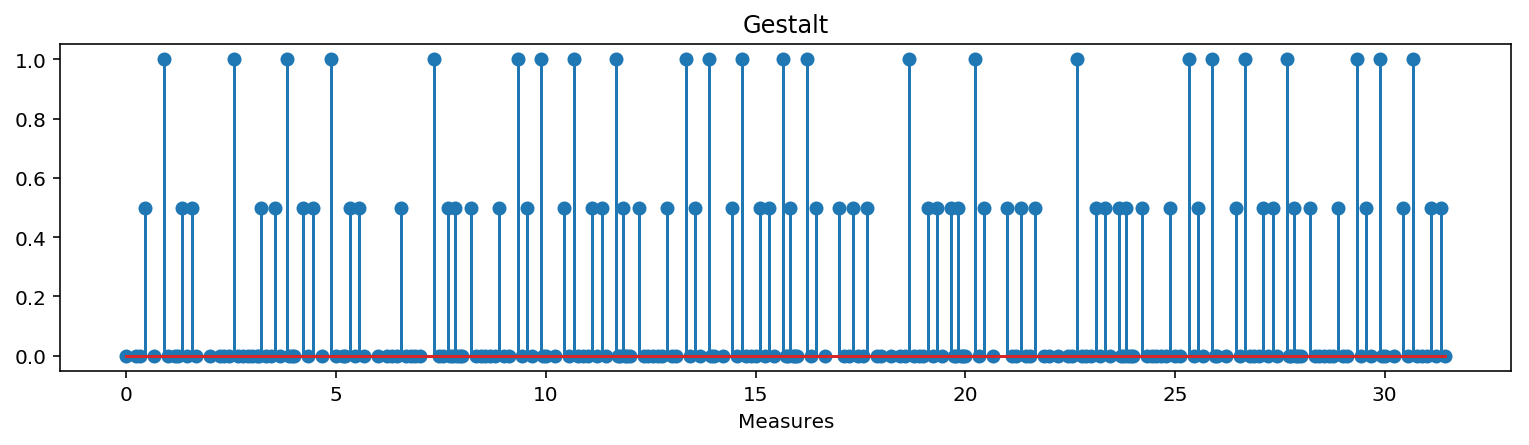

In [10]:
plt.figure(figsize=(13, 3))
plt.stem(onsets, gestalt_profile)
plt.xlabel('Measures')
plt.title('Gestalt')

Unlike LBDM there is no sensitivity parameter for gestalt, and while we show the clang boundaries on the figure, they are not an output of algorithm.

## Reading ground truth
SymbTr dataset has txt files with section boundary annotations that we are going to use as ground truth for the experiment.

In [11]:
from symbtrdataextractor.dataextractor import DataExtractor
extractor = DataExtractor()

In [12]:
def get_section_offsets(txt_filename):
    txt_data, is_data_valid = extractor.extract(txt_filename)
    
    with open(txt_filename) as fp:
        raw_txt = fp.readlines()

    get_offset = lambda x: raw_txt[x].split()[-1]

    section_notes = [[section['start_note'], section['end_note']] for section in txt_data['sections']]
    sections = [[get_offset(start-1), get_offset(end)] for start, end in section_notes]
    return np.array(sections, dtype=float)

sections = get_section_offsets('txt/{}.txt'.format(test_filename))
print(sections)

[[ 0.  4.]
 [ 4.  8.]
 [ 8. 12.]
 [12. 16.]
 [16. 20.]
 [20. 24.]
 [24. 28.]
 [28. 32.]]


Text(0.5,0,'Measures')

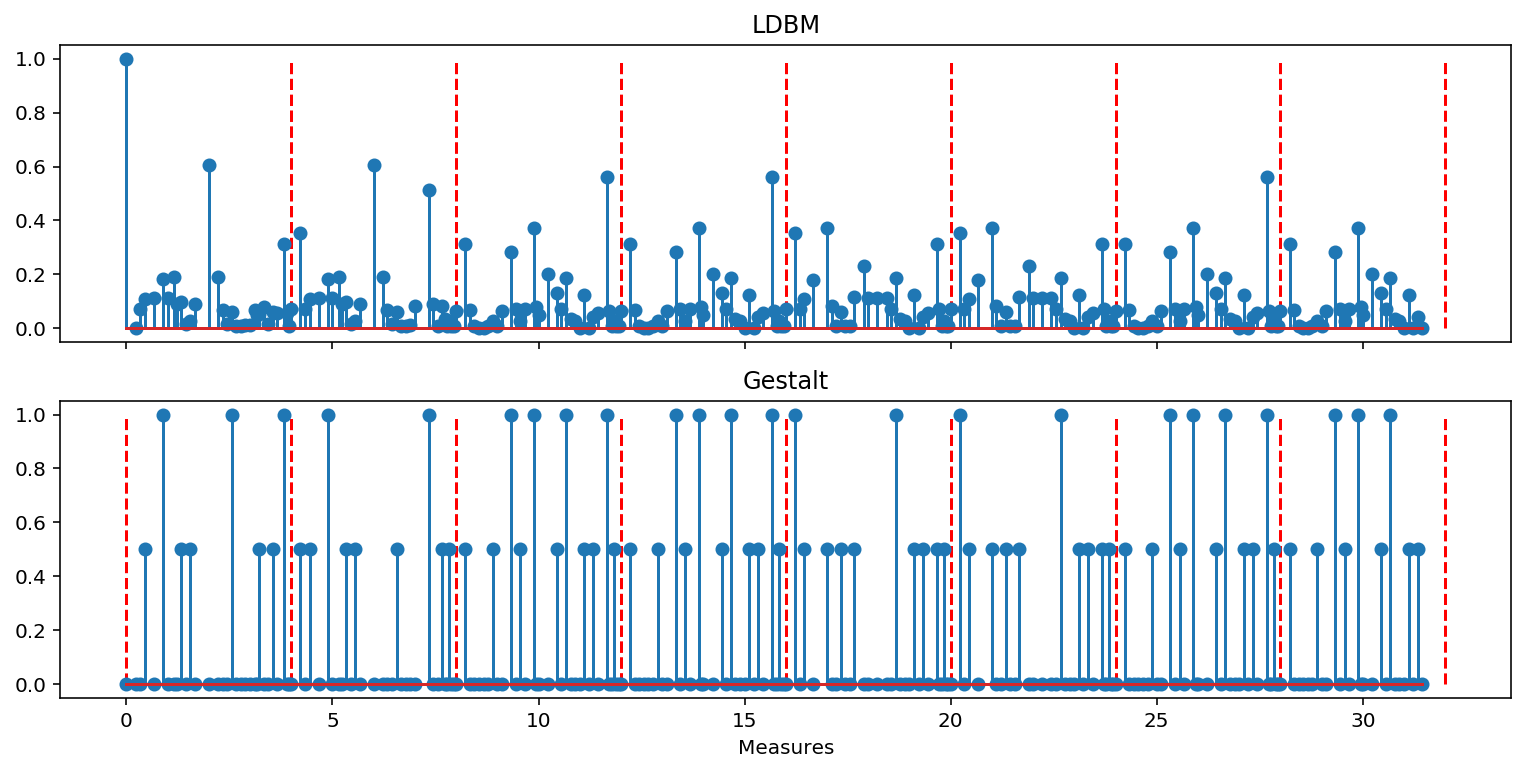

In [13]:
f, ax = plt.subplots(2, figsize=(13, 6), sharex=True)

ax[0].stem(onsets, profile)
ax[0].set_title('LDBM')

ax[1].stem(onsets, gestalt_profile)
ax[1].set_title('Gestalt')

for ax_obj in ax:
    ax_obj.vlines(sections, 0, 1, 'r', linestyles='dashed')
plt.xlabel('Measures')

Here you can see both of LBDM profile function and Gestalt cland and segment boundaries plotted together with the ground truth section boundaries shown in red dotted lines

## Evaluation
We will use [mir-eval](https://github.com/craffel/mir_eval) tool for the evaluation purposes. It has segmenation bundary evaluation framework that is aplicable to our experiment.

In [14]:
from mir_eval.segment import evaluate

In [15]:
# transforms array of markers into array of intervals
def get_intervals(est_boundaries, end):
    est_intervals = []
    
    for i in range(len(est_boundaries)-1):
        est_intervals.append([est_boundaries[i], est_boundaries[i+1]])
    est_intervals.append([est_boundaries[-1], end])
    return np.array(est_intervals)

In [16]:
# performs evaluation and parses score dictionary to extract metrics we are interested in
def get_performance(est_intervals):
    scores = evaluate(sections, ['']*len(sections), est_intervals, ['']*len(est_intervals))
    return scores['F-measure@0.5'], scores['F-measure@3.0']

For LBDM algorithm we want to try several threshold factors and pick the best performance that can be achieved. Although in real-world application the selection of threshold is big problem on its own, currently we are interested in comparing the algorithms

In [17]:
def eval_lbdm(onsets, profile, end, delta=21):
    w_values = np.linspace(0.1, 0.9, delta)

    f05 = []
    f30 = []
    
    for threshold in w_values:
        est_intervals = get_intervals(onsets[profile > threshold], end)
        _f05, _f30 = get_performance(est_intervals)
        f05.append(_f05)
        f30.append(_f30)

    return w_values, f05, f30, np.max(f05), np.max(f30)

w_values, f05, f30, maxf05, maxf30 = eval_lbdm(onsets, profile, end)

Highest LBDM performance: F@0.5: 0.588235294118, F@3.0: 0.823529411765 


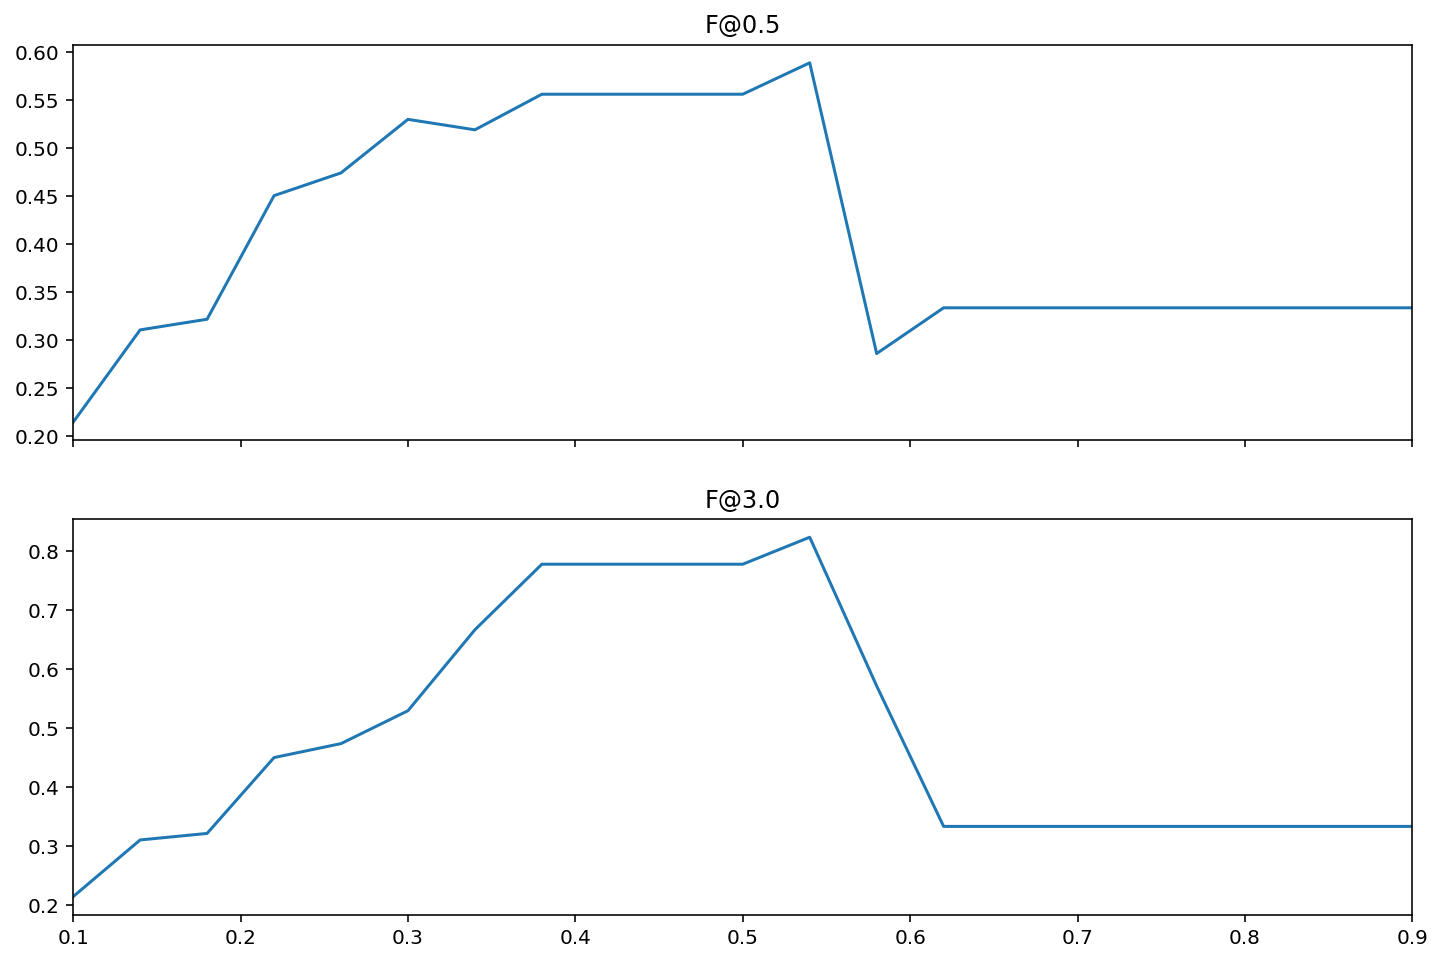

In [23]:
f, ax = plt.subplots(2, figsize=[12,8], sharex=True)
ax[0].plot(w_values, f05)
ax[0].set_title('F@0.5')
ax[1].plot(w_values, f30)
ax[1].set_title('F@3.0')
for ax_obj in ax:
    ax_obj.set_xlim(min(w_values), max(w_values))
    
print('Highest LBDM performance: F@0.5: {}, F@3.0: {} '.format(maxf05, maxf30))

On the figure above we can see plot of F-measure vs the threshold value. F-measure is a harmonic mean between precision and recall, thus it deteriorates significantly when either does. Thus we can see that the threshold value close to 0.55 would give the maximum performance of the LBDM algorithm

In [19]:
def eval_gestalt(onsets, mask, end):
    est_intervals = get_intervals(onsets[mask], end)
    return get_performance(est_intervals)

print('Segments (F@0.5, F@3.0): {:4.3f}, {:4.3f}'.format(*eval_gestalt(onsets, segments, end)))
print('Clangs   (F@0.5, F@3.0): {:4.3f}, {:4.3f}'.format(*eval_gestalt(onsets, clangs, end)))


Segments (F@0.5, F@3.0): 0.389, 0.500
Clangs   (F@0.5, F@3.0): 0.198, 0.198


As expected, clang bundaries are too numerous to be useful for section detection, so the performance is low. Segment boundaries perform much better, however the F-measures are pretty low compared to LBDM.

We can see that LBDM gets higher performance because of the flexibility of the threshold tuning, while gestalt segmentation is locked in to fixed segment boundaries with no parameters that can be adjusted.

## Final evaluation on the dataset
Now let's run the algorithms on number of midi files and look at the average performance metrics. There are a lot of issues with the data, thus we only aggregate performance metrics from the data that was able to be processed. Some of the issues include bad midi format, polyphony in midi files, broken anotation files, etc.

In [20]:
import os
from __future__ import print_function

In [21]:
%%capture
results = []
limit = 20

for name in os.listdir('midi'):
    try:
        midi_data = m21.converter.parse('midi/{}'.format(name))

        ref_intervals = get_section_offsets('txt/{}'.format(name.replace('.mid', '.txt')))

        onsets, lbdm_profile = lbdm(midi_data)
        qpm = get_quarters_per_measure(midi_data)
        end = midi_data.duration.quarterLength / qpm
        onsets = onsets / qpm

        _, _, gestalt_segments = gestalt(midi_data)
    
        _, _, _, lbdm_f05, lbdm_f30 = eval_lbdm(onsets, lbdm_profile, end)
        gestalt_f05, gestalt_f30 = eval_gestalt(onsets, gestalt_segments, end)
        
        results.append([lbdm_f05, gestalt_f05, lbdm_f30, gestalt_f30])
        
    except Exception:
        pass
    
    if len(results) >= limit:
        break

Text(0.5,1,'Boundary detection peformance')

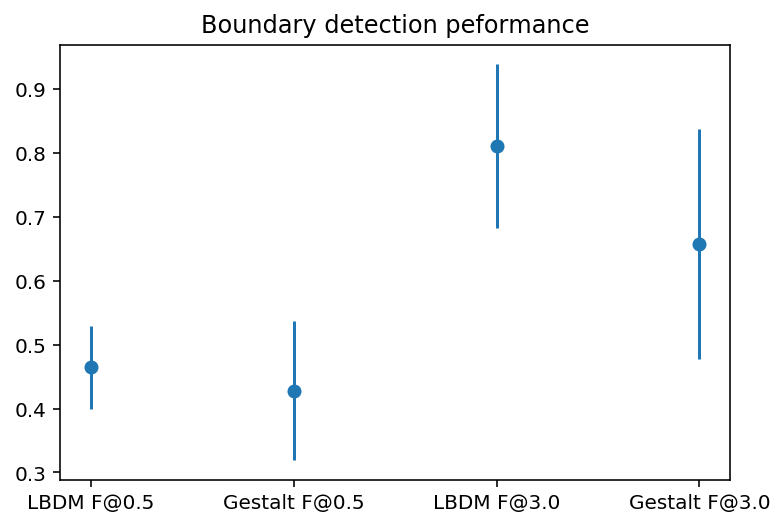

In [22]:
avg_results = np.mean(np.array(results), axis=0)
std_results = np.std(np.array(results), axis=0)
x = np.arange(4)

plt.errorbar(x, avg_results, std_results, linestyle='None', marker='o')
plt.xticks(x, ['LBDM F@0.5', 'Gestalt F@0.5', 'LBDM F@3.0' , 'Gestalt F@3.0'])
plt.title('Boundary detection peformance')

This figure shows the comparison of the average performance of segmentation algorithms: LBDM and Gestalt. We see that LBDM performs better. That is primarily because of the ability to change the sensitivity of the algorithm based on threshold. However both algorithms use different approaches, thus the comparison depends on the dataset. Maybe LBDM works better for turkish music, while Gestalt has other advatanges that can be exploited in different dataset